In [1]:
import math
import matplotlib.pyplot as plt
import sklearn.feature_selection
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import pandas as pd
import numpy as np

import wrangle

## Grades Data

In [2]:
df = wrangle.wrangle_grades()

In [3]:
train, test = sklearn.model_selection.train_test_split(df, random_state=123, train_size=.8)

predictions = pd.DataFrame({'actual': train.final_grade})

In [4]:
X, y = train[['exam1']], train.final_grade
# equivalent to
# X = train[['exam1']]
# y = train.final_grade

lm = sklearn.linear_model.LinearRegression().fit(X, y)
predictions['final_grade ~ exam1'] = lm.predict(X)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:533: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [5]:
X, y = train[['exam2']], train.final_grade

lm = sklearn.linear_model.LinearRegression().fit(X, y)
predictions['final_grade ~ exam2'] = lm.predict(X)

In [6]:
X, y = train[['exam1', 'exam3']], train.final_grade

lm = sklearn.linear_model.LinearRegression().fit(X, y)
predictions['final_grade ~ exam1 + exam3'] = lm.predict(X)

In [7]:
predictions.apply(lambda c: sklearn.metrics.mean_squared_error(predictions.actual, c))

actual                          0.000000
final_grade ~ exam1             3.405933
final_grade ~ exam2            16.067423
final_grade ~ exam1 + exam3     2.861172
dtype: float64

In [8]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

[Text(0.5, 1.0, 'final_grade ~ exam1 + exam3')]

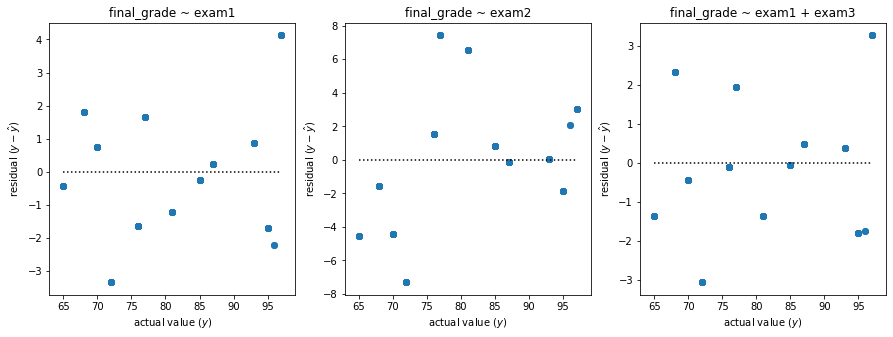

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(131) # 131 -- 1 row, 3 columns, 1st subplot
ax = plot_residuals(predictions.actual, predictions['final_grade ~ exam1'])
ax.set(title='final_grade ~ exam1')

plt.subplot(132) # 132 -- 1 row, 3 columns, 2nd subplot
ax = plot_residuals(predictions.actual, predictions['final_grade ~ exam2'])
ax.set(title='final_grade ~ exam2')

plt.subplot(133)
ax = plot_residuals(predictions.actual, predictions['final_grade ~ exam1 + exam3'])
ax.set(title='final_grade ~ exam1 + exam3')
# note the scale of the y-axis on all the subplots

Text(0.5, 0, 'actual')

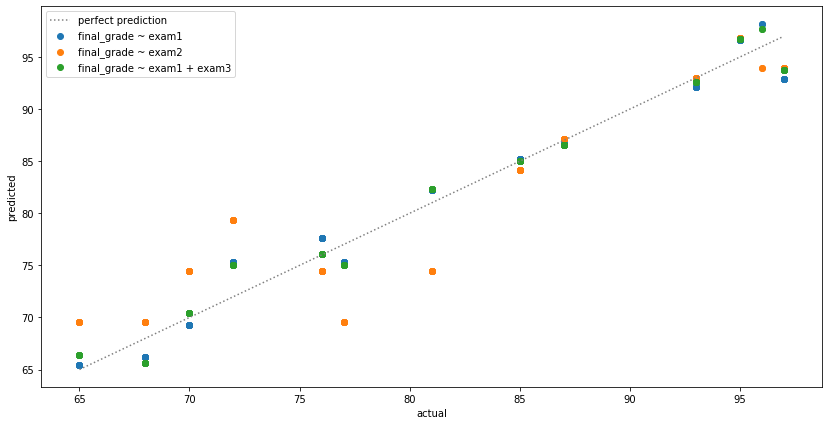

In [14]:
plt.figure(figsize=(14, 7))

# plt.scatter(x, y, label='whatever shows up in the legend')
plt.scatter(predictions.actual, predictions['final_grade ~ exam1'], label='final_grade ~ exam1')
plt.scatter(predictions.actual, predictions['final_grade ~ exam2'], label='final_grade ~ exam2')
plt.scatter(predictions.actual, predictions['final_grade ~ exam1 + exam3'], label='final_grade ~ exam1 + exam3')
# creates the straight line for perfect prediction
plt.plot(
    [predictions.actual.min(), predictions.actual.max()],
    [predictions.actual.min(), predictions.actual.max()],
    ls=':',
    label='perfect prediction',
    c='grey'
)
plt.legend()


plt.ylabel('predicted')
plt.xlabel('actual')

- **in-sample error**: error on the train dataset
- **out-of-sample error**: error on the test dataset

[Text(0.5, 1.0, 'Test Residuals -- MSE: 3.98')]

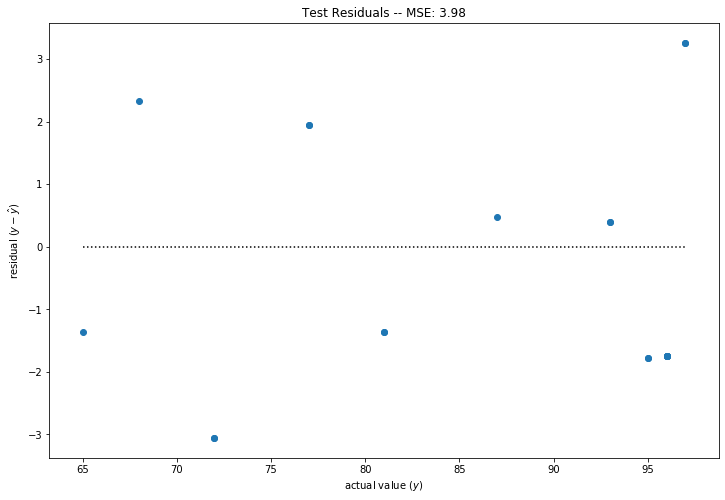

In [16]:
# evaluate the best model on the test data set
X, y = train[['exam1', 'exam3']], train.final_grade

lm = sklearn.linear_model.LinearRegression().fit(X, y)

y_test = test.final_grade
y_test_predicted = lm.predict(test[['exam1', 'exam3']])

mse = sklearn.metrics.mean_squared_error(y_test, y_test_predicted)

plt.figure(figsize=(12, 8))
ax = plot_residuals(y_test, y_test_predicted)
ax.set(title=f'Test Residuals -- MSE: {mse:.2f}')

## Telco

In [17]:
# How should pandas output float numbers?
pd.options.display.float_format = '{:.3f}'.format

In [18]:
telco = wrangle.wrangle_telco()

train, test = sklearn.model_selection.train_test_split(telco, random_state=123)
predictions = pd.DataFrame({'actual': train.total_charges})

In [19]:
X, y = train[['tenure']], train.total_charges

lm = sklearn.linear_model.LinearRegression().fit(X, y)
predictions['total_charges ~ tenure'] = lm.predict(X)

In [20]:
X, y = train[['monthly_charges']], train.total_charges

lm = sklearn.linear_model.LinearRegression().fit(X, y)
predictions['total_charges ~ monthly_charges'] = lm.predict(X)

In [21]:
X, y = train[['tenure', 'monthly_charges']], train.total_charges

lm = sklearn.linear_model.LinearRegression().fit(X, y)
predictions['total_charges ~ tenure + monthly_charges'] = lm.predict(X)

In [22]:
predictions.apply(lambda c: sklearn.metrics.mean_squared_error(predictions.actual, c))

actual                                           0.000
total_charges ~ tenure                     4040535.210
total_charges ~ monthly_charges             735691.354
total_charges ~ tenure + monthly_charges    243936.789
dtype: float64

In [23]:
# RFE + PolynomialFeatures

# 1. create polynomial features
# 2. Use RFE to determine which of the polynomial features are good
# 3. Use the resulting features in our model

X, y = train[['tenure', 'monthly_charges']], train.total_charges
X

,tenure,monthly_charges
691,67,25.100
1497,72,111.600
1055,4,19.500
1556,50,70.350
306,68,95.100
...,...,...
1122,72,88.700
1346,66,25.150
1406,70,39.150
1389,71,83.200


In [24]:
poly = sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly.fit(X)
X_poly = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names(X.columns))
X_poly

,tenure,monthly_charges,tenure monthly_charges
0,67.000,25.100,1681.700
1,72.000,111.600,8035.200
2,4.000,19.500,78.000
3,50.000,70.350,3517.500
4,68.000,95.100,6466.800
...,...,...,...
1266,72.000,88.700,6386.400
1267,66.000,25.150,1659.900
1268,70.000,39.150,2740.500
1269,71.000,83.200,5907.200


In [25]:
lm = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(lm, 1)
rfe.fit(X_poly, y)
X_rfe = pd.DataFrame(rfe.transform(X_poly), columns=X_poly.columns[rfe.support_])
X_rfe

,tenure monthly_charges
0,1681.700
1,8035.200
2,78.000
3,3517.500
4,6466.800
...,...
1266,6386.400
1267,1659.900
1268,2740.500
1269,5907.200


In [26]:
lm = sklearn.linear_model.LinearRegression().fit(X_rfe, y)
predictions['total_charges ~ tenure:monthly_charges'] = lm.predict(X_rfe)

In [27]:
predictions.apply(lambda c: sklearn.metrics.mean_squared_error(predictions.actual, c))

actual                                           0.000
total_charges ~ tenure                     4040535.210
total_charges ~ monthly_charges             735691.354
total_charges ~ tenure + monthly_charges    243936.789
total_charges ~ tenure:monthly_charges        7262.606
dtype: float64

In [32]:
X_test, y_test = test[['tenure', 'monthly_charges']], test.total_charges

# we can't just pass in X_test, we must apply the same transformations that we did to train
lm.predict(X_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [35]:
# applying to test
X_test, y_test = test[['tenure', 'monthly_charges']], test.total_charges

# Using the existing poly, rfe, and lm objects
X_test_poly = poly.transform(X_test)
X_test_rfe = rfe.transform(X_test_poly)
y_test_predictions = lm.predict(X_test_rfe)

sklearn.metrics.mean_squared_error(y_test, y_test_predictions)

6892.767255428307

## Share y-axis in visualizing residuals

two ways to use matplotlib

- `plt.whatever`
- Create figure and axis objects and use those

In [38]:
def plot_residuals(ax, actual, predicted):
    residuals = actual - predicted
    ax.hlines(0, actual.min(), actual.max(), ls=':')
    ax.scatter(actual, residuals)
    ax.set(ylabel='residual ($y - \hat{y}$)', xlabel='actual value ($y$)', title='Actual vs Residual')

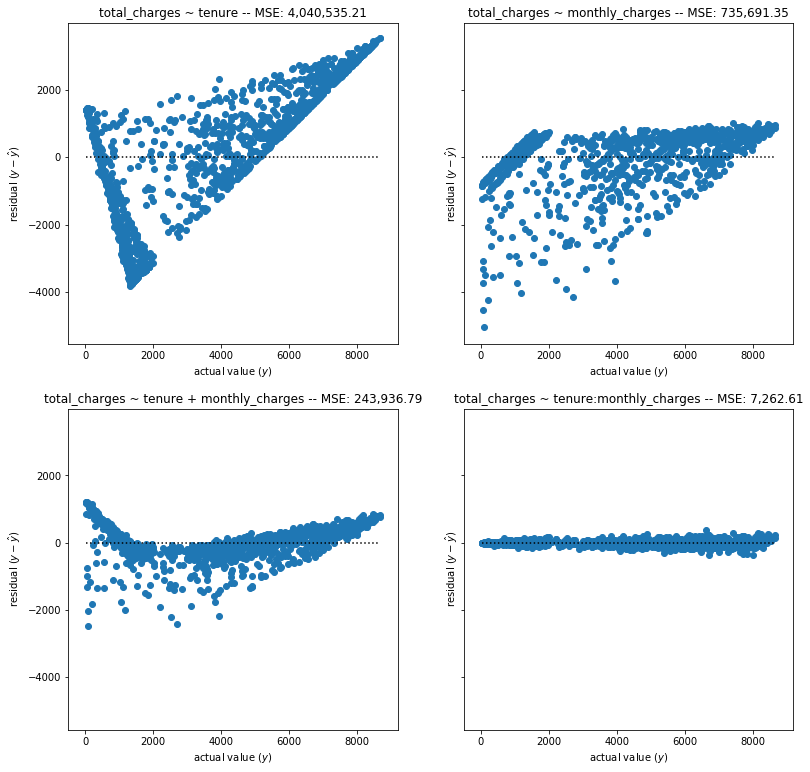

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharey=True)

for ax, col in zip(axs.ravel(), predictions.iloc[:, 1:]):
    plot_residuals(ax, predictions.actual, predictions[col])
    mse = sklearn.metrics.mean_squared_error(predictions.actual, predictions[col])
    ax.set(title=f'{col} -- MSE: {mse:,.2f}')